In this notebook, we are going to make a text classification model using Neural Network and glove embedding.

The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg).

I used the 

In [2]:
import os
from gensim import models
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
embeddings_index = {}
f = open('../embeddings/glove.6B/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [4]:
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [5]:
# Reading data
train_df = pd.read_csv('../Data/imdb_master.csv', encoding = "ISO-8859-1")

In [6]:
train_df.head()

Unnamed: 0  type                                             review label  \
0           0  test  Once again Mr. Costner has dragged out a movie...   neg   
1           1  test  This is an example of why the majority of acti...   neg   
2           2  test  First of all I hate those moronic rappers, who...   neg   
3           3  test  Not even the Beatles could write songs everyon...   neg   
4           4  test  Brass pictures (movies is not a fitting word f...   neg   

          file  
0      0_2.txt  
1  10000_4.txt  
2  10001_1.txt  
3  10002_3.txt  
4  10003_3.txt

In [7]:
train_df = train_df.drop(["Unnamed: 0","file", "type"], axis=1)

In [8]:
train_df.label.value_counts()

unsup    50000
neg      25000
pos      25000
Name: label, dtype: int64

In [9]:
train_df = train_df[train_df.label != 'unsup']
train_df["label"] = train_df["label"].map({"pos":1,"neg":0})

In [10]:
train_df.head()

review  label
0  Once again Mr. Costner has dragged out a movie...      0
1  This is an example of why the majority of acti...      0
2  First of all I hate those moronic rappers, who...      0
3  Not even the Beatles could write songs everyon...      0
4  Brass pictures (movies is not a fitting word f...      0

In [11]:
# Cleaning and Pre Processing text
import re

def clean_numbers(text):
    text = re.sub('[0-9]{5,}', '#####', text)
    text = re.sub('[0-9]{4}', '####', text)
    text = re.sub('[0-9]{3}', '###', text)
    text = re.sub('[0-9]{2}', '##', text)
    return text

def clean_text(text):
    text = clean_numbers(text)
    text = str(text)

    for punct in "/-'":
        text = text.replace(punct, ' ')
    for punct in '&':
        text = text.replace(punct, f' {punct} ')
    for punct in '?!.,"$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        text = text.replace(punct, '')

    text = text.lower()
    return text

In [12]:
# Test the above pre process function
clean_text("Hi this Is the test For 894 y ~is okay")

'hi this is the test for ### y is okay'

In [13]:
# Clean text in dataFrame
train_df["processed_data"] = train_df["review"].progress_apply(lambda x: clean_text(x))
train_df["length"] = train_df["processed_data"].progress_apply(lambda x: len(x.split()))

100%|██████████| 50000/50000 [00:01<00:00, 36903.72it/s]


In [14]:
train_df.head(5)

review  label  \
0  Once again Mr. Costner has dragged out a movie...      0   
1  This is an example of why the majority of acti...      0   
2  First of all I hate those moronic rappers, who...      0   
3  Not even the Beatles could write songs everyon...      0   
4  Brass pictures (movies is not a fitting word f...      0   

                                      processed_data  length  
0  once again mr costner has dragged out a movie ...     171  
1  this is an example of why the majority of acti...     244  
2  first of all i hate those moronic rappers who ...     232  
3  not even the beatles could write songs everyon...     321  
4  brass pictures movies is not a fitting word fo...     241

In [15]:
# The average length of sentences
train_df["length"].mean()

237.12282

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b91aa90>]],
      dtype=object)

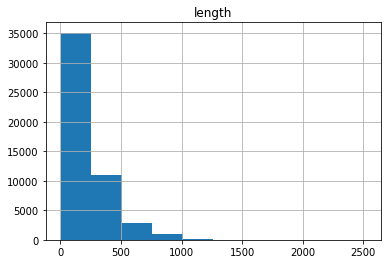

In [16]:
# Check the histogram 
train_df.hist("length")

In [17]:
docs = train_df["processed_data"].values
labels = train_df["label"].values

In [18]:
# Import gc, clearing some memory in ram
import gc
del train_df
gc.collect()

41

In [19]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 150
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [21]:
# Create Train/Test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_docs, labels, test_size=0.2, random_state=42)

In [25]:
# define model
model = Sequential()
e = Embedding(input_dim=vocab_size, output_dim=50, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)

model.add(Dense(1024, activation='relu'))
#model.add(Dense(512, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 50)           7018250   
_________________________________________________________________
dense_5 (Dense)              (None, 150, 1024)         52224     
_________________________________________________________________
dense_6 (Dense)              (None, 150, 64)           65600     
_________________________________________________________________
flatten_2 (Flatten)          (None, 9600)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9601      
Total params: 7,145,675
Trainable params: 127,425
Non-trainable params: 7,018,250
_________________________________________________________________
None


In [26]:
reduce_err = EarlyStopping(monitor='val_loss', 
                           min_delta=0,patience=0,
                           verbose=0, mode='auto')

In [27]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          epochs=15, batch_size=256, callbacks=[reduce_err])

Train on 40000 samples, validate on 10000 samples
Epoch 1/15
40000/40000 [==============================] - 120s 3ms/step - loss: 0.5388 - acc: 0.7183 - val_loss: 0.4353 - val_acc: 0.8063
Epoch 2/15
40000/40000 [==============================] - 117s 3ms/step - loss: 0.4058 - acc: 0.8165 - val_loss: 0.3903 - val_acc: 0.8266
Epoch 3/15
40000/40000 [==============================] - 119s 3ms/step - loss: 0.3642 - acc: 0.8415 - val_loss: 0.3722 - val_acc: 0.8352
Epoch 4/15
40000/40000 [==============================] - 118s 3ms/step - loss: 0.3351 - acc: 0.8541 - val_loss: 0.3642 - val_acc: 0.8406
Epoch 5/15
40000/40000 [==============================] - 116s 3ms/step - loss: 0.3030 - acc: 0.8724 - val_loss: 0.3622 - val_acc: 0.8432
Epoch 6/15
40000/40000 [==============================] - 118s 3ms/step - loss: 0.2797 - acc: 0.8853 - val_loss: 0.3690 - val_acc: 0.8463


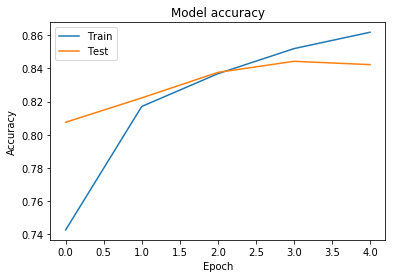

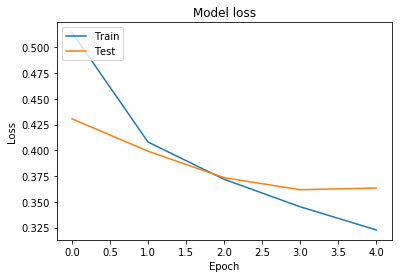

In [93]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()